# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [85]:
!pip install networkx==2.3
!pip install stellargraph

In [86]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [6]:
from google.colab import files
files= files.upload()

Saving movie_actor_network.csv to movie_actor_network.csv


In [87]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [88]:
edges = [tuple(x) for x in data.values.tolist()]

In [89]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [90]:
A = list(nx.connected_component_subgraphs(B))[0]

In [91]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


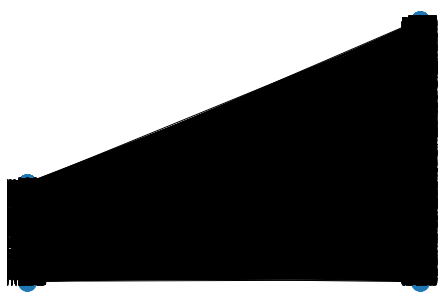

In [92]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [93]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [94]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [95]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [96]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [97]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [98]:
print(node_ids)

['a973', 'a967', 'a1731', 'a964', 'a970', 'a969', 'a1057', 'a1028', 'a1003', 'a965', 'm1094', 'm67', 'a959', 'a988', 'a966', 'a49', 'a1037', 'a962', 'a93', 'm1111', 'a971', 'm1100', 'a963', 'a1030', 'a1076', 'a977', 'a960', 'a1027', 'a1016', 'm1095', 'a204', 'a472', 'a768', 'a631', 'm1001', 'a968', 'a1004', 'a1020', 'a1035', 'm1112', 'a1026', 'a1507', 'a975', 'a2715', 'm453', 'a972', 'a306', 'a1031', 'a407', 'a138', 'a1036', 'm1022', 'm1096', 'a987', 'm1114', 'm987', 'm376', 'a1008', 'm1113', 'm1261', 'm148', 'a205', 'a1435', 'm26', 'm126', 'a1021', 'm1272', 'm816', 'm1232', 'a921', 'a782', 'a1038', 'm964', 'm796', 'm25', 'm1097', 'm121', 'm1220', 'm154', 'm32', 'a976', 'm1000', 'm1357', 'm1106', 'm990', 'm122', 'a1436', 'a1467', 'a1015', 'm75', 'm616', 'a1011', 'a1060', 'a974', 'm988', 'm147', 'a1750', 'm1090', 'm890', 'm1045', 'm165', 'a893', 'a1005', 'm1348', 'a228', 'm1284', 'm1023', 'm1213', 'm982', 'a1505', 'm902', 'm115', 'm915', 'm1092', 'm157', 'm918', 'm155', 'm1024', 'm963',

In [99]:
print(node_embeddings)

[[-0.02169183 -0.67798245  0.2899146  ...  0.5731205   0.57977986
   0.46749902]
 [ 0.5520878   0.06158654 -0.9725307  ...  1.8266393   0.37417302
   1.2325723 ]
 [-0.07724241  0.7037871   1.0842186  ...  0.06976801 -1.5312365
  -0.25526813]
 ...
 [-0.13665247  0.02191455  0.12799856 ... -0.1705572  -0.02483279
  -0.06061648]
 [-0.06001134  0.00544932  0.03469339 ... -0.02009667  0.02640934
   0.05098146]
 [-0.08023974  0.01295233  0.02445881 ... -0.07162193 -0.0194059
  -0.04534758]]


In [100]:
print(node_targets)

['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'movie', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'actor', 'movie', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'actor', 'actor', 'actor', 'actor', 'movie', 'actor', 'actor', 'actor', 'actor', 'movie', 'actor', 'actor', 'actor', 'actor', 'movie', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'movie', 'actor', 'movie', 'movie', 'movie', 'actor', 'movie', 'movie', 'movie', 'actor', 'actor', 'movie', 'movie', 'actor', 'movie', 'movie', 'movie', 'actor', 'actor', 'actor', 'movie', 'movie', 'movie', 'movie', 'movie', 'movie', 'movie', 'movie', 'actor', 'movie', 'movie', 'movie', 'movie', 'movie', 'actor', 'actor', 'actor', 'movie', 'movie', 'actor', 'actor', 'actor', 'movie', 'movie', 'actor', 'movie', 'movie', 'movie', 'movie', 'actor', 'actor', 'movie', 'actor', 'movie', 'movie', 'movie', 'movie', 'actor', 'movie', 

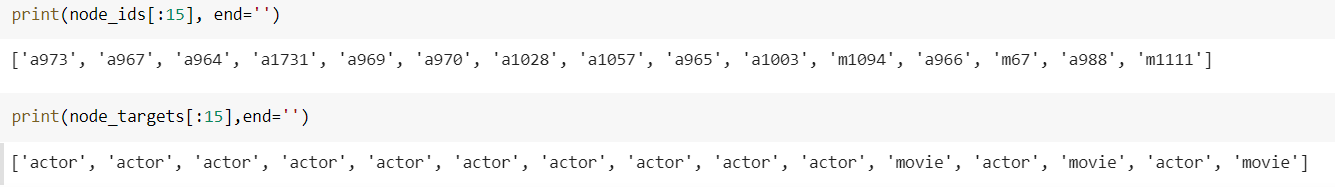

In [135]:
def data_split(node_ids,node_targets,node_embeddings):
  actor_nodes,movie_nodes=[],[]
  actor_embeddings,movie_embeddings=[],[]

#In this function, we will split the node embeddings into actor_embeddings , movie_embeddings
#split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids


  actor_embedding = [actor_embeddings.append(x) for i,x in enumerate(node_embeddings) if node_targets[i]=='actor']
  actor_node = [actor_nodes.append(x) for i,x in enumerate(node_ids) if node_targets[i]=='actor']

  movie_embedding = [movie_embeddings.append(x) for i,x in enumerate(node_embeddings) if node_targets[i]=='movie']
  movie_node = [movie_nodes.append(x) for i,x in enumerate(node_ids) if node_targets[i]=='movie']
  
  return actor_nodes, movie_nodes, actor_embeddings, movie_embeddings
    
  # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
  # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
  
  # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
  # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
  # By using node_ids and node_targets, we can extract actor_nodes and movie nodes

In [136]:
#L=actor_nodes
#M=movie_nodes
#N=actor_embeddings
#O=movie_embeddings
L,M,N,O = data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [137]:
def grader_actors(data):
  assert(len(data)==3411)
  return True
grader_actors(L)

True

<font color='cyan'>Grader function - 2</font>

In [138]:
def grader_movies(data):
  assert(len(data)==1292)
  return True
grader_movies(M)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [105]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    num= max([len(x) for x in list(nx.connected_components(graph))])
    Total_Nodes=graph.number_of_nodes()
    cost1= (num/Total_Nodes)*(1/number_of_clusters)
    return cost1

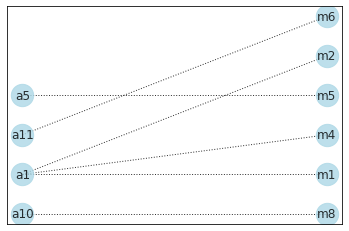

In [106]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [107]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [108]:
def cost2(graph,number_of_clusters):
  d=graph.degree()
  nodes=list(graph.nodes())
  unique=[]

  for i in nodes:
    if i not in unique:
      unique.append(i)

  sum=0
  for i in d:
    if 'a' in i[0]:
      sum+=i[1]

  mov=0
  for i in unique:
    if 'm' in i:
      mov+=1
  cost2=sum/mov

  return cost2 /number_of_clusters

<font color='cyan'>Grader function - 4</font>

In [109]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

In [80]:
print(node_ids)

['a973', 'a967', 'a964', 'a970', 'a1731', 'a969', 'a1028', 'a965', 'a1003', 'a1057', 'm1094', 'a966', 'a988', 'm1111', 'a959', 'm1100', 'm67', 'a1037', 'a93', 'a962', 'a49', 'a971', 'a963', 'm1095', 'a1030', 'a1076', 'a977', 'a1016', 'a960', 'a1027', 'a204', 'a472', 'a768', 'a968', 'a1004', 'a1020', 'a2715', 'a631', 'a1026', 'a1035', 'm1001', 'a1507', 'a306', 'a972', 'a407', 'm816', 'a1031', 'm1112', 'a975', 'm376', 'a138', 'm1113', 'm1261', 'm1096', 'a1036', 'm1097', 'm987', 'm1272', 'a1435', 'a1008', 'a205', 'm1114', 'a987', 'm1022', 'a921', 'm148', 'a1038', 'm453', 'm26', 'm1357', 'm1232', 'm165', 'm126', 'a1467', 'm990', 'a1060', 'm796', 'a976', 'm1220', 'a1021', 'm25', 'm32', 'm890', 'm1106', 'a1015', 'a1436', 'm964', 'a782', 'm75', 'm147', 'm1108', 'a1011', 'm1090', 'm121', 'm1092', 'm1045', 'm1213', 'm1000', 'm1101', 'a1505', 'm157', 'a974', 'a1005', 'a893', 'm1185', 'm743', 'm1098', 'a363', 'm122', 'a228', 'a1750', 'm115', 'm1172', 'm924', 'm125', 'm914', 'm1284', 'a1023', 'm13

In [31]:
from sklearn.cluster import KMeans

cluster_list=[3,5,10,30,50,100,200,500]
Cost=[]

for cluster in cluster_list:
  algo=KMeans(n_clusters=cluster)
  algo.fit(N)
  label=algo.labels_
  dic=dict(zip(L,label))
  cost_1=0
  cost_2=0
  for i in label:
    ac_node = [k for k,v in dic.items() if v == i]
    G1=nx.Graph()
    for n in ac_node:
      
      sub_graph1 = nx.ego_graph(A,n)
      G1.add_nodes_from(sub_graph1.nodes)
      G1.add_edges_from(sub_graph1.edges())
    
    cost_1=+cost1(G1,cluster)
    cost_2=+cost2(G1,cluster)

  print(cost_1*cost_2)
  Cost.append(cost_1*cost_2)

0.4389958060164164
0.15558609248634825
0.021645825791723552
9.397004847985241e-05
3.099886419043271e-05
6.3023061278697754e-06
1.2187674483528756e-06
2.6929392446633827e-07


In [110]:
cost_1=+cost1(G1,cluster)
cost_2=+cost2(G1,cluster)

In [111]:
print(cost_1*cost_2)
Cost.append(cost_1*cost_2)

2.6929392446633827e-07


<font color='blue'>Displaying similar actor clusters</font>

In [112]:
best_cluster=cluster_list[Cost.index(max(Cost))]

In [113]:
best_cluster

3

In [114]:
from sklearn.cluster import KMeans
k_means=KMeans(n_clusters=best_cluster)
k_means.fit(N)
print(k_means.cluster_centers_)

[[-1.43657022e-01  2.05439373e-02  1.54603767e-01 -5.40951188e-02
  -1.51872968e-01  2.73666262e-02 -6.53429919e-02 -1.73805032e-01
  -2.89610202e-01 -4.65922230e-04 -1.81507820e-01  1.81745397e-01
   5.52906040e-02 -6.38083864e-02  1.86831050e-01  3.13497972e-02
  -1.28343303e-01  1.13872437e-01 -2.37880467e-02 -6.83178697e-02
   7.31850669e-02  4.07889509e-02 -1.58659587e-01  9.02188298e-02
  -5.95764820e-03 -5.57135012e-02  1.41782324e-01 -3.79609754e-02
  -4.21341083e-02 -1.84641033e-02  6.73481430e-02 -2.10328760e-02
   7.88762576e-02 -1.38613540e-01  9.38835552e-02  6.77082387e-03
  -1.36461022e-01 -8.69453469e-02  2.19063922e-01  2.41163348e-01
  -8.02727759e-02  9.79222652e-02 -4.10645863e-02 -1.05325097e-01
   2.44188557e-01 -1.81267767e-02  1.38223178e-01  3.66801771e-02
  -8.96793103e-02 -5.37353346e-02 -3.28809389e-02  6.36669126e-02
  -1.92087068e-01  2.77550026e-02 -1.48618251e-01  8.17457483e-02
   3.59524831e-01  1.39390022e-01 -3.77530938e-03  2.83680308e-02
   1.96372

In [115]:
print(k_means.labels_)

[1 1 2 ... 0 0 0]


In [116]:
from sklearn.manifold import TSNE

In [117]:
#dimension data for actor node:
dimension_data_for_actor_node = N

dimension_data_for_actor_node_array=np.asarray([dimension_data_for_actor_node])
dimension_data_for_actor_node_array.shape


(1, 3411, 128)

In [55]:
dimension_data_for_actor_node_final=np.reshape(dimension_data_for_actor_node_array,(3411,128))
dimension_data_for_actor_node_final.shape

(3411, 128)

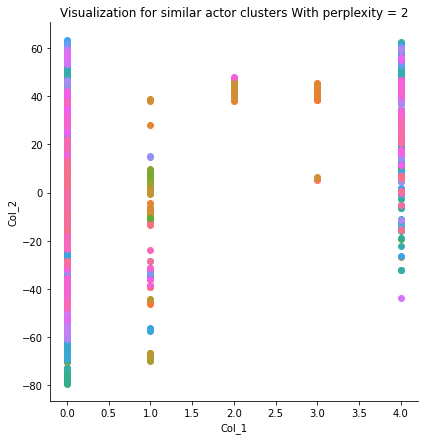

In [62]:
#step2:apply kmeans algorithm on data using n_cluster
from sklearn.cluster import KMeans
#here we are considering n_clusters=5
kmeans= KMeans(n_clusters=5) 
kmeans.fit(dimension_data_for_actor_node_final)
#now Kmeans model contain five clusters and each cluster contain similar actor nodes
predicted_cluster=kmeans.predict(dimension_data_for_actor_node_final)

#Step3:

from sklearn.manifold import TSNE
#TSNE_model = TSNE 

TSNE_model = TSNE(n_components=2)

#apply TSNE model on the "dimension data for actor node" to reduce 128 dimensions to 2 dimensions
two_dimensional_data = TSNE_model.fit_transform(dimension_data_for_actor_node_final)

#now 2 dimensional data contains 3411 rows and 2 dimensions
two_dimensional_data_shape= two_dimensional_data.shape

#step4: Perform Verticle Stacking
#By using vstack() function which is present inside the numpy module, we are going to perform verticle stacking on the transpose data of "two_dimensional_data" & "predicted_cluster"
#Taking Transpose:
transpose_predicted_cluster = predicted_cluster.T
transpose_two_dimensional_data = two_dimensional_data.T

required_data = np.vstack((transpose_predicted_cluster,transpose_two_dimensional_data))

#Now shape of required data is (3, 3411)
#step5:
#use DataFrame() function present in pandas module to convert the transposed_required_data into a dataframe
import pandas as pd
import seaborn as sn

final_data = pd.DataFrame(required_data.T, columns= ["Col_1","Col_2","Label"])
#now final_data is a DataFrame, which contain 3411 rows and 3 columns

#Ploting the result of tsne

sn.FacetGrid(final_data, hue="Label", size=6).map(plt.scatter, 'Col_1', 'Col_2')
plt.title('Visualization for similar actor clusters With perplexity = 2')
plt.show()


<font color='blue'>Grouping similar movies</font>

In [139]:
from sklearn.cluster import KMeans

cluster_list5=[3,5,10,30,50,100,200,500]
Cost5=[]

for cluster in cluster_list5:
  algo5=KMeans(n_clusters=cluster)
  algo5.fit(O)
  label=algo5.labels_
  dic=dict(zip(M,label))
  cost_15=0
  cost_25=0
  for i in label:
    ac_node5 = [k for k,v in dic.items() if v == i]
    G15=nx.Graph()
    for n in ac_node5:
      
      sub_graph15 = nx.ego_graph(A,n)
      G15.add_nodes_from(sub_graph15.nodes)
      G15.add_edges_from(sub_graph15.edges())
    
    cost_15=+cost1(G15,cluster)
    cost_25=+cost2(G15,cluster)

  print(cost_15*cost_25)
  Cost5.append(cost_15*cost_25)

0.6991793052399112
0.20491804955381115
0.020149620748715444
0.0013918095418521677
0.00042443845954037756
5.5247471703167915e-05
7.104987917913947e-06
4.779686333084392e-07


<font color='blue'>Displaying similar movie clusters</font>

In [140]:
best_cluster1=cluster_list5[Cost5.index(max(Cost5))]

In [141]:
best_cluster1

3

In [142]:
cost_15=+cost1(G15,cluster)
cost_25=+cost2(G15,cluster)

In [143]:
print(cost_15*cost_25)
Cost5.append(cost_15*cost_25)

4.779686333084392e-07


In [144]:
from sklearn.cluster import KMeans
k_means5=KMeans(n_clusters=best_cluster1)
k_means5.fit(O)
print(k_means.cluster_centers_)

[[-1.43657022e-01  2.05439373e-02  1.54603767e-01 -5.40951188e-02
  -1.51872968e-01  2.73666262e-02 -6.53429919e-02 -1.73805032e-01
  -2.89610202e-01 -4.65922230e-04 -1.81507820e-01  1.81745397e-01
   5.52906040e-02 -6.38083864e-02  1.86831050e-01  3.13497972e-02
  -1.28343303e-01  1.13872437e-01 -2.37880467e-02 -6.83178697e-02
   7.31850669e-02  4.07889509e-02 -1.58659587e-01  9.02188298e-02
  -5.95764820e-03 -5.57135012e-02  1.41782324e-01 -3.79609754e-02
  -4.21341083e-02 -1.84641033e-02  6.73481430e-02 -2.10328760e-02
   7.88762576e-02 -1.38613540e-01  9.38835552e-02  6.77082387e-03
  -1.36461022e-01 -8.69453469e-02  2.19063922e-01  2.41163348e-01
  -8.02727759e-02  9.79222652e-02 -4.10645863e-02 -1.05325097e-01
   2.44188557e-01 -1.81267767e-02  1.38223178e-01  3.66801771e-02
  -8.96793103e-02 -5.37353346e-02 -3.28809389e-02  6.36669126e-02
  -1.92087068e-01  2.77550026e-02 -1.48618251e-01  8.17457483e-02
   3.59524831e-01  1.39390022e-01 -3.77530938e-03  2.83680308e-02
   1.96372

In [145]:
print(k_means5.labels_)

[2 2 2 ... 0 0 0]


In [146]:
from sklearn.manifold import TSNE

In [147]:
#dimension data for movie node:
dimension_data_for_movie_node = O

dimension_data_for_movie_node_array=np.asarray([dimension_data_for_movie_node])
dimension_data_for_movie_node_array.shape

(1, 1292, 128)

In [148]:
dimension_data_for_movie_node_final=np.reshape(dimension_data_for_movie_node_array,(1292,128))
dimension_data_for_movie_node_final.shape

(1292, 128)

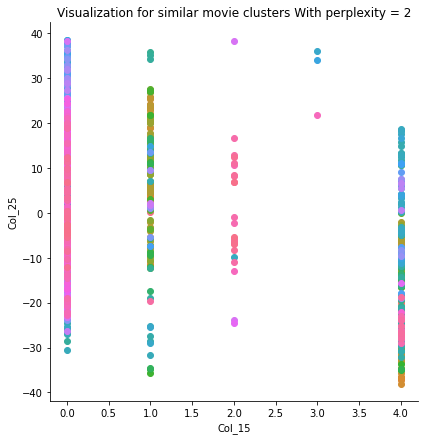

In [149]:
#step2:apply kmeans algorithm on data using n_cluster
from sklearn.cluster import KMeans
#here we are considering n_clusters=5
kmeans5= KMeans(n_clusters=5) 

kmeans5.fit(dimension_data_for_movie_node_final)
#now Kmeans model contain five clusters and each cluster contain similar movie nodes
predicted_cluster5=kmeans.predict(dimension_data_for_movie_node_final)

#Step3:

from sklearn.manifold import TSNE
#TSNE_model = TSNE 

TSNE_model5 = TSNE(n_components=2)

#apply TSNE model on the "dimension data for actor node" to reduce 128 dimensions to 2 dimensions
two_dimensional_data5 = TSNE_model5.fit_transform(dimension_data_for_movie_node_final)

#now 2 dimensional data contains 3411 rows and 2 dimensions
two_dimensional_data5_shape= two_dimensional_data5.shape

#step4: Perform Verticle Stacking
#By using vstack() function which is present inside the numpy module, we are going to perform verticle stacking on the transpose data of "two_dimensional_data5" & "predicted_cluster5"
#Taking Transpose:
transpose_predicted_cluster5 = predicted_cluster5.T
transpose_two_dimensional_data5 = two_dimensional_data5.T

required_data5 = np.vstack((transpose_predicted_cluster5,transpose_two_dimensional_data5))

#Now shape of required data is (3, 1292)
#step5:
#use DataFrame() function present in pandas module to convert the transposed_required_data into a dataframe
import pandas as pd
import seaborn as sn

final_data5 = pd.DataFrame(required_data5.T, columns= ["Col_15","Col_25","Label5"])
#now final_data is a DataFrame, which contain 1292 rows and 3 columns

#Ploting the result of tsne

sn.FacetGrid(final_data5, hue="Label5", size=6).map(plt.scatter, 'Col_15', 'Col_25')
plt.title('Visualization for similar movie clusters With perplexity = 2')
plt.show()
